In [10]:
# %pip install PyPDF2

import os
import PyPDF2
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_text_splitters import TextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from dotenv import load_dotenv

Loading the Documents

In [11]:
# File path for the document
folder_path = r"C:\Users\ggsan\Desktop\Ironhack\2. LABS\8.WEEK\project-5-2-genai-rag\data\Finance_laws\EurLex_v1"

In [12]:
print(os.path.exists(folder_path))  # Should be True if the folder exists
print(os.path.isdir(folder_path))   # Should be True if it's a directory

True
True


In [13]:
pdf_texts = []

for filename in os.listdir(folder_path):
    if filename.lower().endswith(".pdf"):
        pdf_path = os.path.join(folder_path, filename)
        
        with open(pdf_path, 'rb') as pdf_file:
            pdf_reader = PyPDF2.PdfReader(pdf_file)
            text_content = []
            for page in pdf_reader.pages:
                text_content.append(page.extract_text())
            combined_text = "\n".join(text_content)
            pdf_texts.append((filename, combined_text))

In [14]:
# 2. Split texts into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100
)


In [15]:
documents = []
for filename, text in pdf_texts:
    splits = text_splitter.split_text(text)
    for i, chunk in enumerate(splits):
        documents.append({
            "page_content": chunk,
            "metadata": {
                "source": filename,
                "chunk_id": i
            }
        })

In [16]:
len(chunk)

976

In [17]:
len(documents)

4324

Embeddings

In [18]:
os.environ["OPENAI_API_KEY"] = "you own key here"
embedding_function = OpenAIEmbeddings(model="text-embedding-3-large", api_key=os.environ["OPENAI_API_KEY"])

C:\Users\ggsan\AppData\Local\Temp\ipykernel_9328\219618664.py:2: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding_function = OpenAIEmbeddings(model="text-embedding-3-large", api_key=os.environ["OPENAI_API_KEY"])


In [19]:
from langchain.vectorstores import Chroma


In [20]:
# Assuming Document is a class with attributes 'page_content' and 'metadata'
class Document:
    def __init__(self, page_content, metadata):
        self.page_content = page_content
        self.metadata = metadata

# Example list of dictionaries
documents_dicts = [
    {"page_content": "Content of document 1", "metadata": {"author": "Author 1"}},
    {"page_content": "Content of document 2", "metadata": {"author": "Author 2"}},
]

# Convert dictionaries to Document objects
documents = [Document(doc["page_content"], doc["metadata"]) for doc in documents_dicts]

In [21]:
db = Chroma.from_documents(
    documents=documents,
    embedding=embedding_function,
    collection_name="my_pdf_collection"
)


Retrieving Documents

In [22]:
user_question = "can you explain waht is financial markets?" # User question
retrieved_docs = db.similarity_search(user_question, k=11) # k is the number of documents to retrieve

Number of requested results 11 is greater than number of elements in index 2, updating n_results = 2


In [23]:
# Display top results
for i, doc in enumerate(retrieved_docs[:1]): # Display top 3 results
    print(f"Document {i+1}:\n{doc.page_content[0:1000]}") # Display content

Document 1:
Content of document 2


Preparing Content for GenAI

In [24]:
def _get_document_prompt(docs):
    prompt = "\n"
    for doc in docs:
        prompt += "\nContent:\n"
        prompt += doc.page_content + "\n\n"
    return prompt

In [25]:
# Generate a formatted context from the retrieved documents
formatted_context = _get_document_prompt(retrieved_docs)
print("Context formatted for GPT model.")

Context formatted for GPT model.


ChatBot Architecture

In [26]:
# user_question = "can you explain GDSs?"  # Define the user question

prompt = f"""
## SYSTEM ROLE
You are a knowledgeable and factual chatbot designed to assist with technical questions about **Finance**, specifically focusing on **Financial legislation in Europe**. 
Your answers must be based exclusively on provided content from technical pdf's provided.

## USER QUESTION
The user has asked: 
"{user_question}"

## CONTEXT
Here is the relevant content from the technical pdf's:  
'''
{formatted_context}
'''

## GUIDELINES
1. **Accuracy**:  
   - Only use the content in the `CONTEXT` section to answer.  
   - If the answer cannot be found, explicitly state: "The provided context does not contain this information."

2. **Transparency**:  
   - Reference the pdf's name and page numbers when providing information.  
   - Do not speculate or provide opinions.  

3. **Clarity**:  
   - Use simple, professional, and concise language.  
   - Format your response in Markdown for readability.  

## TASK
1. Answer the user's question **directly** if possible.  
2. Point the user to relevant parts of the documentation.  
3. Provide the response in the following format:

## RESPONSE FORMAT
'''
# [Brief Title of the Answer]
[Answer in simple, clear text.]

**Source**:  
• [Document Title], Page(s): [...]
'''
"""
print("Prompt constructed.")
print("Prompt constructed.")

Prompt constructed.
Prompt constructed.


In [27]:
# pip install openai==0.28

In [28]:
import openai

# Set up GPT client and parameters
OPEN_API_KEY = os.getenv("OPENAI_API_KEY")
client = openai.ChatCompletion.create(
    api_key=OPEN_API_KEY,
    model="gpt-4o",
    temperature=0.7,  # Increase creativity
    max_tokens=4000,  # Allow for longer responses
    top_p=0.8,        # Use nucleus sampling
    frequency_penalty=0.5,  # Reduce repetition
    presence_penalty=0.6,   # Encourage new topics
    messages=[
        {"role": "system", "content": "You are a knowledgeable and factual chatbot."},
        {"role": "user", "content": user_question}
    ]
)

In [68]:
messages = [
	{"role": "system", "content": "You are a knowledgeable and factual chatbot."},
	{"role": "user", "content": user_question}
]

model_params = {
	"model": "gpt-4o",
	"temperature": 0.7, # more reduce more relvaante
	"max_tokens": 4000,
	"top_p": 0.9,
	"frequency_penalty": 0.5,
	"presence_penalty": 0.6
}

openai.api_key = os.getenv("OPENAI_API_KEY")

completion = openai.ChatCompletion.create(messages=messages, **model_params, timeout=120)

# users questions... 
can you explain what is financial markets?
can you explain content od this pdf's?
can you explain GDSs

In [67]:
user_question = "can you explain GDSs?" # User question

Response

In [69]:
answer = completion.choices[0].message.content
print(answer)

Certainly! GDS stands for Global Distribution System. It is a computerized network system that enables transactions between travel industry service providers, mainly airlines, hotels, car rental companies, and travel agencies. The primary purpose of a GDS is to facilitate the booking and reservation process for travel-related services on a global scale.

Here are some key points about GDSs:

1. **Functionality**: GDSs provide real-time inventory and pricing information to travel agents and other distribution channels. They aggregate data from various service providers, allowing users to search for availability, compare prices, and make bookings.

2. **Major Players**: The main GDS operators include Amadeus, Sabre, and Travelport (which operates Galileo and Worldspan). These systems are widely used by travel agencies worldwide.

3. **History**: Originally developed in the 1960s by major airlines as internal systems to manage flight reservations more efficiently, GDSs have evolved over t

In [32]:

from langchain_openai import OpenAIEmbeddings
from langchain.embeddings import HuggingFaceEmbeddings

In [59]:
from langchain.embeddings import OpenAIEmbeddings, HuggingFaceEmbeddings

openai_embeddings = OpenAIEmbeddings(model="text-embedding-ada-002", api_key=OPEN_API_KEY)
sentence_transformer_embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [34]:
from sklearn.decomposition import PCA

In [35]:
openai_vector = openai_embeddings.embed_query(user_question)
sentence_vector = sentence_transformer_embeddings.embed_query(user_question)

In [36]:
len(openai_vector)

1536

In [37]:
len(sentence_vector)

384

In [38]:
# Truncate the higher-dimensional embedding to match the lower-dimensional one
if len(openai_vector) > len(sentence_vector):
	openai_vector = openai_vector[:len(sentence_vector)] # slice the vector to match the length of the other
elif len(sentence_vector) > len(openai_vector):
	sentence_vector = sentence_vector[:len(openai_vector)]

In [39]:
len(openai_vector)

384

In [40]:
len(sentence_vector)

384

In [41]:
# Compare the two sets
common_elements = set(openai_vector[:5]).intersection(set(sentence_vector[:5]))
unique_to_openai = set(openai_vector[:5]) - set(sentence_vector[:5])
unique_to_sentence_transformer = set(sentence_vector[:5]) - set(openai_vector[:5])

print(f"Common elements: {common_elements}\n")
print(f"1. OpenAI Embeddings: \n   {unique_to_openai}\n")
print(f"2. SentenceTransformer Embeddings: \n    {unique_to_sentence_transformer}")

Common elements: set()

1. OpenAI Embeddings: 
   {0.014476875286238368, -0.011379796627758381, -0.022044331954403328, -0.021200324624917822, -0.013196558246424005}

2. SentenceTransformer Embeddings: 
    {-0.10340530425310135, -0.026149217039346695, -0.03187628462910652, 0.013983393087983131, 0.06065914034843445}


Cosine Similarity

In [42]:
from scipy.spatial.distance import cosine

In [43]:
similarity = 1 - cosine(openai_vector, sentence_vector)
print(f"Cosine Similarity between OpenAI and SentenceTransformer embeddings: {similarity:.4f}")

Cosine Similarity between OpenAI and SentenceTransformer embeddings: 0.0532


- **-1**: Vectors are completely opposite.
-   **0**: Vectors are orthogonal (uncorrelated or unrelated).
-   **1**: Vectors are identical.

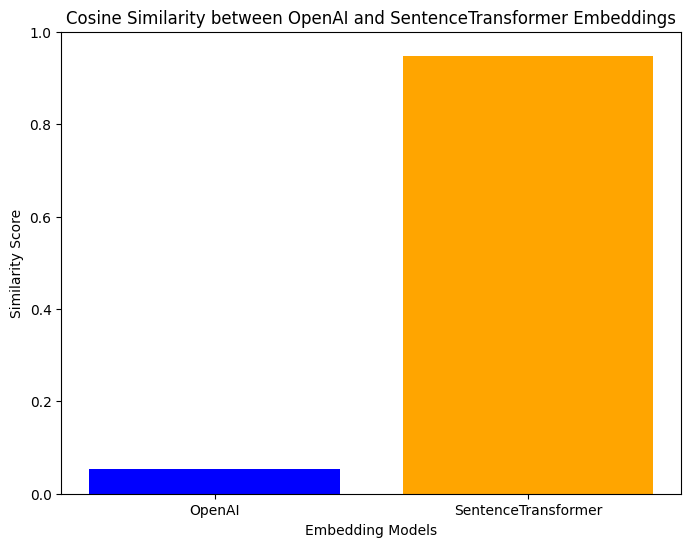

In [47]:
# %pip install matplotlib

import matplotlib.pyplot as plt

# Data for plotting
labels = ['OpenAI', 'SentenceTransformer']
similarity_scores = [similarity, 1 - similarity]

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, similarity_scores, color=['blue', 'orange'])
plt.xlabel('Embedding Models')
plt.ylabel('Similarity Score')
plt.title('Cosine Similarity between OpenAI and SentenceTransformer Embeddings')
plt.ylim(0, 1)
plt.show()